# Classify names to the country they might correspond

Classifying names with a character-level RNN

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [2]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('name_data/names/*.txt'))

['name_data/names\\Arabic.txt', 'name_data/names\\Chinese.txt', 'name_data/names\\Czech.txt', 'name_data/names\\Dutch.txt', 'name_data/names\\English.txt', 'name_data/names\\French.txt', 'name_data/names\\German.txt', 'name_data/names\\Greek.txt', 'name_data/names\\Irish.txt', 'name_data/names\\Italian.txt', 'name_data/names\\Japanese.txt', 'name_data/names\\Korean.txt', 'name_data/names\\Polish.txt', 'name_data/names\\Portuguese.txt', 'name_data/names\\Russian.txt', 'name_data/names\\Scottish.txt', 'name_data/names\\Spanish.txt', 'name_data/names\\Vietnamese.txt']


In [3]:
all_letters = string.ascii_letters + ".,;''"
n_letters = len(all_letters)

print(all_letters)
print()
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;''

57


# Transform from unicode to ascii

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

In [5]:
print(unicodeToAscii('Björn'))

Bjorn


In [6]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('name_data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
n_categories

18

In [7]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning names to tensors
Create tensor of size (line_length X 1 X n_letters). Middle index is for batch.

In [9]:
print(letterToTensor('J'))
print()
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

torch.Size([5, 1, 57])


# Create the network

Network architecture.


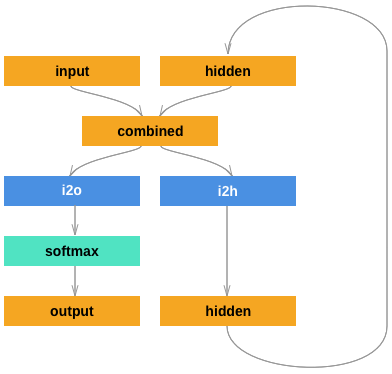

In [10]:
from IPython.display import Image, display
print('Network architecture.')

Image('https://i.imgur.com/Z2xbySO.png')

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = F.relu(self.i2o(combined))
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    
n_hidden = 256
rnn = RNN(n_letters, n_hidden, n_categories)
        
        
        
        

In [12]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

print(output)

tensor([[-2.8515, -2.8904, -2.9725, -2.8519, -2.9319, -2.8786, -2.8478, -2.8977,
         -2.9361, -2.8917, -2.8887, -2.8939, -2.8794, -2.8745, -2.8220, -2.9460,
         -2.8753, -2.9088]], grad_fn=<LogSoftmaxBackward>)


C:\Users\gilbe\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


# Prepare for training

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Russian', 14)


In [14]:

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/ line = ', line)

category =  Arabic / line =  Naifeh
category =  Portuguese / line =  Madeira
category =  Spanish / line =  Acosta
category =  Polish / line =  Jaskulski
category =  Polish / line =  Kowalski
category =  Polish / line =  Bukowski
category =  Japanese / line =  Tsurimi
category =  Vietnamese / line =  Vinh
category =  Japanese / line =  Tomika
category =  Czech / line =  Kauphsman


In [15]:
criterion = nn.NLLLoss()

learning_rate = 0.0003

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # update parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()
        

In [16]:
import time
import math

n_iters = int(1e5)
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return "%dm %ds" % (m, s)

start_time = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'correct' if guess == category else "wrong" 
        print('%d %d%% (%s) %.4f %s / %s %s' % (
            iter, 
            iter / n_iters * 100, 
            timeSince(start_time), 
            loss, 
            line, 
            guess,
            correct)
             )
        
    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.8134 Pena / Spanish correct
10000 10% (0m 21s) 2.8510 OwYang / Portuguese wrong
15000 15% (0m 32s) 2.8056 Rosales / Greek wrong
20000 20% (0m 42s) 2.8769 Shaitan / Irish wrong
25000 25% (0m 53s) 2.9020 Ryu / Polish wrong
30000 30% (1m 3s) 2.8880 Sun / Chinese wrong
35000 35% (1m 13s) 2.7488 Rooiakkers / Greek wrong
40000 40% (1m 24s) 2.4263 Hisamutdinov / Russian correct
45000 45% (1m 34s) 2.7072 Mckay / Irish correct
50000 50% (1m 44s) 2.5724 Saller / German correct
55000 55% (1m 54s) 2.4929 Ebner / German correct
60000 60% (2m 4s) 2.4443 Judkov / Russian correct
65000 65% (2m 14s) 2.3122 Africani / Italian correct
70000 70% (2m 24s) 2.2520 Batsakis / Greek correct
75000 75% (2m 34s) 2.6240 Bonnet / Czech wrong
80000 80% (2m 44s) 2.6208 Viney / Arabic wrong
85000 85% (2m 54s) 2.1482 Kedzierski / Russian wrong
90000 90% (3m 4s) 2.8598 Salazar / Arabic wrong
95000 95% (3m 14s) 2.9077 Frierdich / Russian wrong
100000 100% (3m 25s) 2.7809 Arena / Spanish wrong


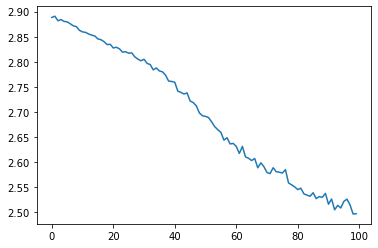

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluate results

C:\Users\gilbe\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-18-25afdc10806d>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-18-25afdc10806d>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


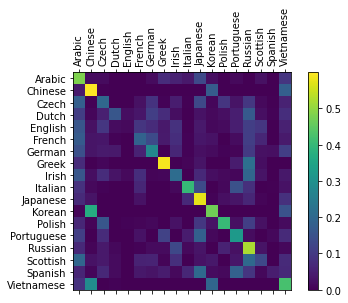

In [18]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()
    

    # Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Predict

In [19]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)    
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
      






In [20]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-2.32) Polish
(-2.47) Czech
(-2.66) Japanese

> Jackson
(-2.37) Scottish
(-2.49) Irish
(-2.62) Russian

> Satoshi
(-2.30) Japanese
(-2.32) Italian
(-2.41) Polish


# Exercises

### Try with a different dataset of line -> category, for example:
  *  Any word -> language
  *  First name -> gender
  *  Character name -> writer
  *  Page title -> blog or subreddit
### Get better results with a bigger and/or better shaped network
  *  Add more linear layers
  *  Try the nn.LSTM and nn.GRU layers
  *  Combine multiple of these RNNs as a higher level network
